In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rc("font", family="Malgun Gothic")

# 0. 데이터 확인

In [2]:
df_info = pd.read_csv('./open/data_info.csv')
df_sample_submission = pd.read_csv('./open/sample_submission.csv')
df_train = pd.read_csv('./open/train.csv')
df_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [3]:
df_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [4]:
df_train = df_train.drop('id', axis=1) #id가 idx와 같으므로 제거

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   base_date              int64  
 1   day_of_week            object 
 2   base_hour              int64  
 3   lane_count             int64  
 4   road_rating            int64  
 5   road_name              object 
 6   multi_linked           int64  
 7   connect_code           int64  
 8   maximum_speed_limit    float64
 9   vehicle_restricted     float64
 10  weight_restricted      float64
 11  height_restricted      float64
 12  road_type              int64  
 13  start_node_name        object 
 14  start_latitude         float64
 15  start_longitude        float64
 16  start_turn_restricted  object 
 17  end_node_name          object 
 18  end_latitude           float64
 19  end_longitude          float64
 20  end_turn_restricted    object 
 21  target                 float64
dtypes: float64(9), int

In [30]:
df_train.describe().T.sort_values(by='std', ascending=False).style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
weight_restricted,4701217.000000,5618.742381,13953.433235,0.000000,0.000000,0.000000,0.000000,50000.000000
target,4701217.000000,42.788442,15.954434,1.000000,30.000000,43.000000,54.000000,113.000000
maximum_speed_limit,4701217.000000,61.253292,12.133539,30.000000,50.000000,60.000000,70.000000,80.000000
base_hour,4701217.000000,11.928196,6.722092,0.000000,6.000000,12.000000,18.000000,23.000000
connect_code,4701217.000000,0.266022,5.227760,0.000000,0.000000,0.000000,0.000000,103.000000
road_rating,4701217.000000,104.958500,1.840107,103.000000,103.000000,106.000000,107.000000,107.000000
road_type,4701217.000000,0.615224,1.211268,0.000000,0.000000,0.000000,0.000000,3.000000
lane_count,4701217.000000,1.836651,0.687751,1.000000,1.000000,2.000000,2.000000,3.000000
start_longitude,4701217.000000,126.521684,0.156366,126.182617,126.423200,126.511195,126.583975,126.930941
end_longitude,4701217.000000,126.521695,0.156352,126.182617,126.423200,126.511195,126.583975,126.930941


In [6]:
df_train["base_date"] = pd.to_datetime(df_train["base_date"],format='%Y%m%d')

In [22]:
df_train["year"] =df_train["base_date"].dt.year
df_train["month"] =df_train["base_date"].dt.month
df_train["date"] =df_train["base_date"].dt.day
df_train.head()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,loc_clusters,year,month,date
0,2022-06-23,목,17,1,106,지방도1112호선,0,60.0,32400.0,3,...,없음,제3교래교,33.427749,126.662335,없음,52.0,1,2022,6,23
1,2022-07-28,목,21,2,103,일반국도11호선,0,60.0,0.0,0,...,있음,KAL사거리,33.504811,126.526240,없음,30.0,5,2022,7,28
2,2021-10-10,일,7,2,103,일반국도16호선,0,80.0,0.0,0,...,없음,상창육교,33.280072,126.362147,없음,61.0,4,2021,10,10
3,2022-03-11,금,13,2,107,태평로,0,50.0,0.0,0,...,없음,서현주택,33.245565,126.566228,없음,20.0,2,2022,3,11
4,2021-10-05,화,8,2,103,일반국도12호선,0,80.0,0.0,0,...,없음,애월입구,33.462677,126.330152,없음,38.0,0,2021,10,5


In [7]:
#multi_linked, vehicle_restricted, height_restricted의 표준편차가 매우작은것으로 보아 값이 별로 없을 수 있음
noVal = ['multi_linked', 'vehicle_restricted', 'height_restricted']
for col in (noVal):
    print(df_train[col].value_counts())

0    4698978
1       2239
Name: multi_linked, dtype: int64
0.0    4701217
Name: vehicle_restricted, dtype: int64
0.0    4701217
Name: height_restricted, dtype: int64


In [8]:
print('multi_linked prop: {0:.4f}'.format(2239/4698978))

multi_linked prop: 0.0005


In [9]:
#셋 다 무의미하므로 drop
df_train = df_train.drop(noVal, axis=1)

In [10]:
df_train.info() #연산 속도를 고려하여 64비트 dtype들을 따로 변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int64         
 3   lane_count             int64         
 4   road_rating            int64         
 5   road_name              object        
 6   connect_code           int64         
 7   maximum_speed_limit    float64       
 8   weight_restricted      float64       
 9   road_type              int64         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_latitude           float64       
 16  end_longitude          float64       
 17  end_turn_restricted    object        
 18  target                

In [11]:
def change_dtype(df, col,dtype):
    for i in col:
        df[i] = df[i].astype(dtype)

In [12]:
change_dtype(df_train, df_train.select_dtypes('int64').columns, 'int32')
change_dtype(df_train, ['maximum_speed_limit', 'weight_restricted', 'target'], 'float32')

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int32         
 3   lane_count             int32         
 4   road_rating            int32         
 5   road_name              object        
 6   connect_code           int32         
 7   maximum_speed_limit    float32       
 8   weight_restricted      float32       
 9   road_type              int32         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_latitude           float64       
 16  end_longitude          float64       
 17  end_turn_restricted    object        
 18  target                

- Int32 -- (-2,147,483,648 to 2,147,483,647)
- float 32 -- 	(-3.4 x 10^38 to 3.4 x 10^38)

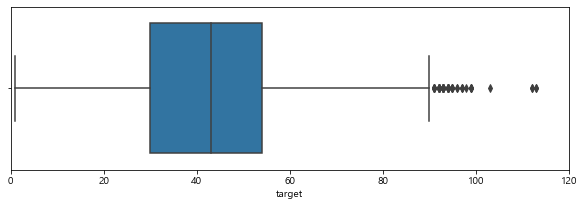

In [15]:
#outlier 확인
plt.figure(figsize=(10,3))
plt.xlim(0,120)
sns.boxplot(x=df_train['target'])

In [14]:
df_train['target'][df_train['target'] > 100]

242903     112.0
2607664    112.0
3841974    113.0
4386692    113.0
4559340    103.0
Name: target, dtype: float32

In [15]:
df_train['road_name'][df_train['target'] > 100] # outlier들의 과적합 방지

242903     일반국도12호선
2607664    일반국도12호선
3841974    일반국도12호선
4386692    일반국도12호선
4559340    일반국도11호선
Name: road_name, dtype: object

In [16]:
df_train = df_train[df_train['target'] < 100]

# 1. NA확인

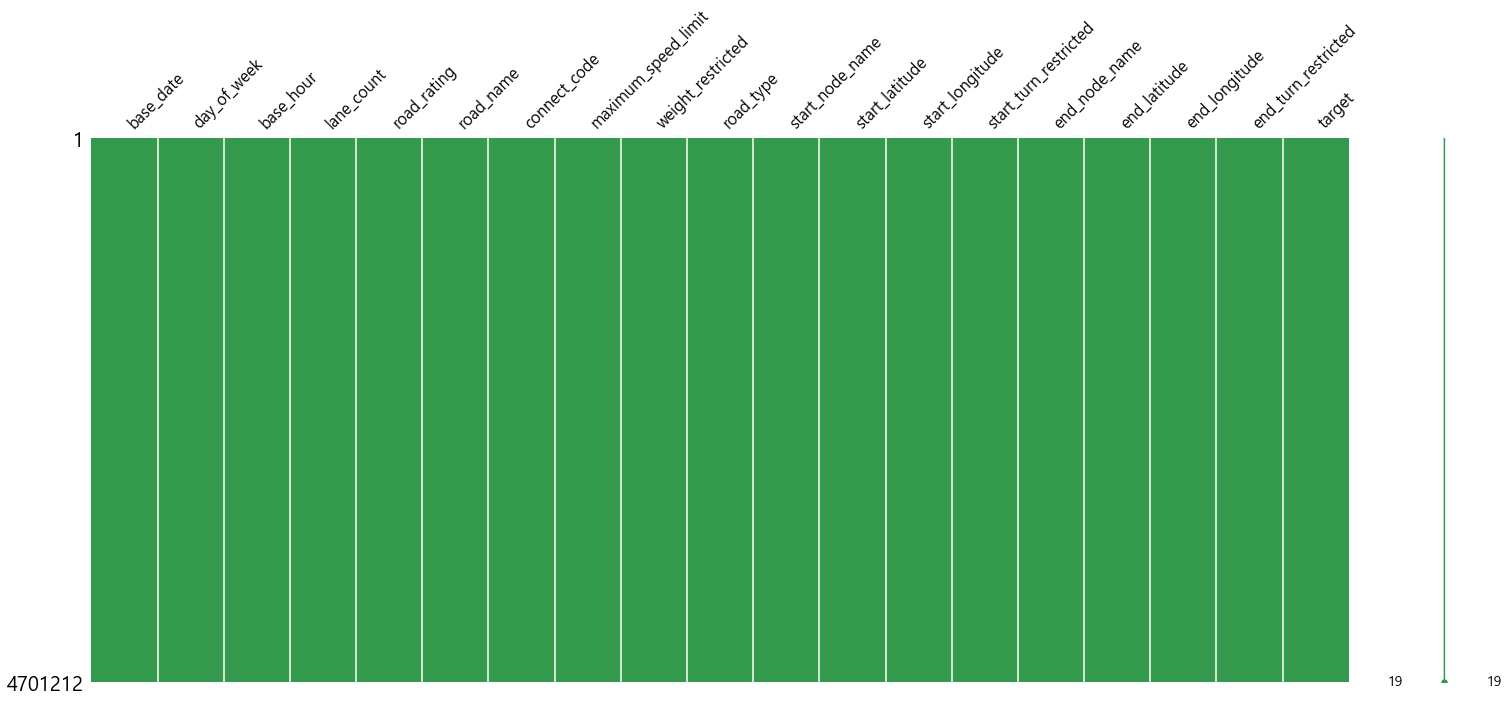

In [19]:
import missingno as msno
msno.matrix(df_train,color=(0.2,0.6,0.3)) # na 값이 없음

# 2. 상관관계 분석

In [41]:
df_train.corr()['target'].sort_values(ascending=False)

target                 1.000000
maximum_speed_limit    0.425720
weight_restricted      0.294094
road_type              0.200842
connect_code           0.048349
start_latitude         0.036285
end_latitude           0.036144
end_longitude         -0.000996
start_longitude       -0.001164
lane_count            -0.144255
base_hour             -0.159402
road_rating           -0.261691
Name: target, dtype: float64

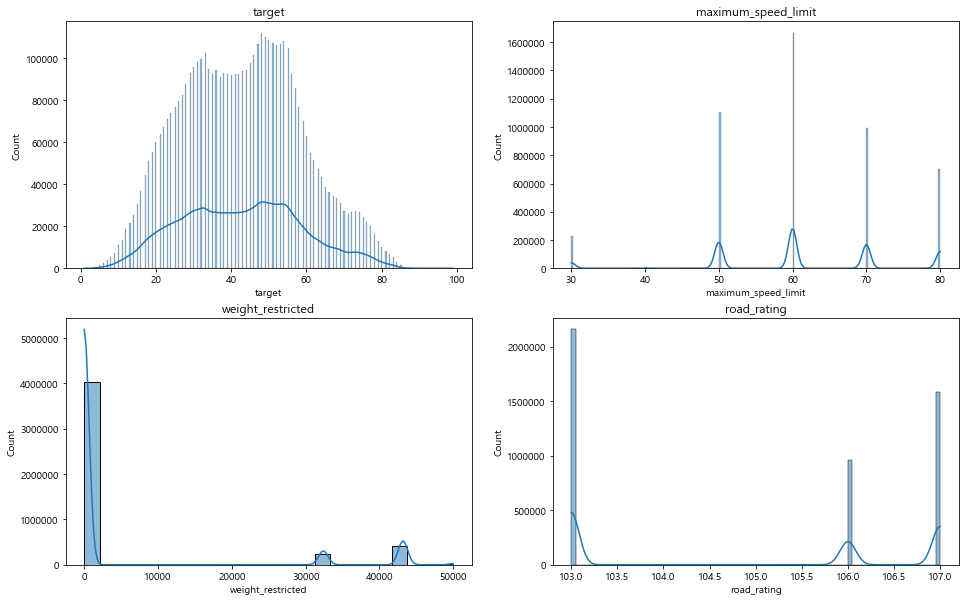

In [21]:
target_corr = abs(df_train.corr()['target']).sort_values(ascending=False)
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.histplot(df_train[target_corr.keys()[i]], kde=True)
    plt.title(target_corr.keys()[i])

1. maximum_speed_limit    0.425715
2. weight_restricted      0.294092
3. road_type              0.200840
4. connect_code           0.048348

# 3. time - location features

## 3.1 시간


    base_date              int64  
    day_of_week            object 
    base_hour              int64  

In [23]:
df_time = df_train[['base_date','day_of_week','base_hour','target']].copy()
df_time.head()

,base_date,day_of_week,base_hour,target
0,2022-06-23,목,17,52.0
1,2022-07-28,목,21,30.0
2,2021-10-10,일,7,61.0
3,2022-03-11,금,13,20.0
4,2021-10-05,화,8,38.0


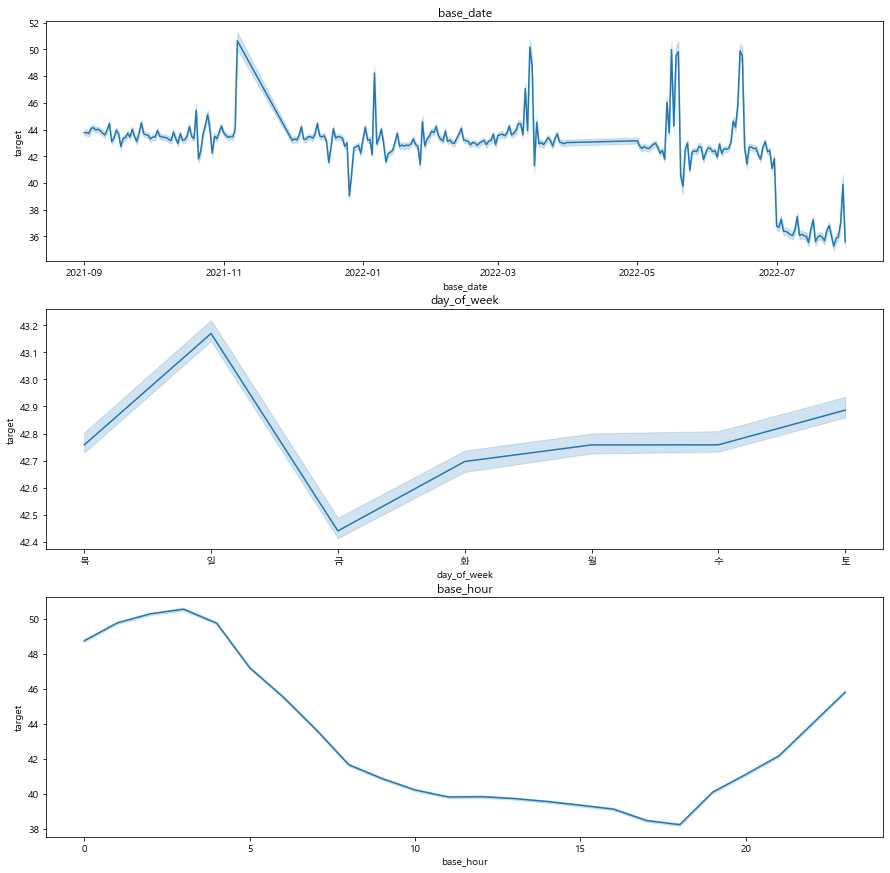

In [25]:
columns = np.array(df_time.columns)
plt.figure(figsize=(15,15))
for i in range(len(columns)-1):
    plt.subplot(3,1,i+1)
    sns.lineplot(x=df_time[columns[i]], y=df_time['target'])
    plt.title(columns[i])

In [21]:
df_time.groupby('day_of_week')['target'].mean().sort_values()

day_of_week
금    42.450123
화    42.698986
월    42.761364
목    42.768345
수    42.770370
토    42.894115
일    43.179211
Name: target, dtype: float32

1. base_date: 7월에서 target이 유의미하게 줄어들었다. 교통이 정체되었다는 것인데 방학 시즌이라 그런 것 같음. 2021년 12월즈음에 갑자기 target이 커지는데 아마도 겨울이기에 눈이 오니 당연히 차가 별로 안다닐 것으로 추정

2. day_of_week: 주말의 시작이 다가오는 금요일이 가장 정체되는걸 알 수 있음. 일요일이 가장 target이 높음
3. base_hour: 당연히 새벽에 가장 정체가 없고, 퇴근시간이 가까워질 수록 정체가 심한걸 알 수 있음

In [24]:
def month(x) : 
    if x ==7 :
        return 2
    elif x in [11,12] :
        return 1
    else :
        return 0
    
def hour(x):
    if x in [16,17,18,19]:
        return 1
    else:
        return 0
    
def week(x):
    if x == '금':
        return 2
    elif x == '일':
        return 0
    else:
        return 1

In [26]:
df_train['m_month'] = df_train['month'].apply(month)
df_train['m_hour'] = df_train['base_hour'].apply(hour)
df_train['m_week'] = df_train['day_of_week'].apply(week)

In [27]:
df_train.head()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,...,end_longitude,end_turn_restricted,target,loc_clusters,year,month,date,m_month,m_hour,m_week
0,2022-06-23,목,17,1,106,지방도1112호선,0,60.0,32400.0,3,...,126.662335,없음,52.0,1,2022,6,23,0,1,1
1,2022-07-28,목,21,2,103,일반국도11호선,0,60.0,0.0,0,...,126.526240,없음,30.0,5,2022,7,28,2,0,1
2,2021-10-10,일,7,2,103,일반국도16호선,0,80.0,0.0,0,...,126.362147,없음,61.0,4,2021,10,10,0,0,0
3,2022-03-11,금,13,2,107,태평로,0,50.0,0.0,0,...,126.566228,없음,20.0,2,2022,3,11,0,0,2
4,2021-10-05,화,8,2,103,일반국도12호선,0,80.0,0.0,0,...,126.330152,없음,38.0,0,2021,10,5,0,0,1


## 3.2 공간

	lane_count 차로수
    road_rating	도로등급
	connect_code 연결로 코드
	maximum_speed_limit 최고속도제한
    weight_restricted 통과제한하중
    road_name 도로명 
    road_type 도로유형
    connect_code 연결로 코드
    start_turn_restricted 시작 지점의 회전제한 유무
    end_turn_restricted 도착 지점의 회전제한 유무

In [49]:
df_train['lane_count'].value_counts() / df_train['lane_count'].count()

2    0.500316
1    0.331516
3    0.168168
Name: lane_count, dtype: float64

In [34]:
df_train.groupby('lane_count').mean()['target'] ## 3차선부터 속도가 현저히 느려짐

lane_count
1    43.570435
2    44.915657
3    34.917782
Name: target, dtype: float32

In [56]:
df_train.groupby('lane_count').describe()['target']

,count,mean,std,min,25%,50%,75%,max
lane_count,,,,,,,,
1,1558528.0,43.571472,13.238388,1.0,34.0,45.0,53.0,99.0
2,2352090.0,44.910900,17.757292,1.0,31.0,45.0,58.0,97.0
3,790594.0,34.917130,12.289639,2.0,26.0,34.0,44.0,98.0


In [57]:
df_train.groupby('road_rating').describe()['target'] #categorical 데이터로 봐야할듯하다

,count,mean,std,min,25%,50%,75%,max
road_rating,,,,,,,,
103,2159506.0,46.384350,16.196743,1.0,35.0,47.0,56.0,97.0
106,959492.0,48.022198,12.527824,1.0,40.0,50.0,56.0,99.0
107,1582214.0,34.700584,14.232207,1.0,24.0,32.0,43.0,94.0


In [58]:
df_train.groupby('connect_code').describe()['target'] #마찬가지로 categorical 데이터로 봐야할듯하다

,count,mean,std,min,25%,50%,75%,max
connect_code,,,,,,,,
0,4689070.0,42.730679,15.898387,1.0,30.0,43.0,54.0,99.0
103,12142.0,57.947044,9.075539,15.0,50.0,57.0,66.0,84.0


In [60]:
df_train['maximum_speed_limit'].unique() #target과 상관관계가 가장 높은 특성

array([60., 80., 50., 70., 30., 40.], dtype=float32)

In [62]:
df_train.groupby('maximum_speed_limit').describe()['target'] #속도제한이 40인 도로에서의 target이 유난히 높고 수가 적음

,count,mean,std,min,25%,50%,75%,max
maximum_speed_limit,,,,,,,,
30.0,229761.0,32.220825,9.642290,1.0,25.0,33.0,40.0,60.0
40.0,6790.0,62.774078,8.780591,15.0,61.0,65.0,69.0,84.0
50.0,1103680.0,35.493057,12.833925,1.0,26.0,34.0,44.0,99.0
60.0,1665572.0,42.319923,14.064423,1.0,31.0,44.0,53.0,99.0
70.0,995075.0,41.364967,14.902983,2.0,30.0,43.0,53.0,98.0
80.0,700334.0,60.702152,13.533126,3.0,52.0,62.0,72.0,94.0


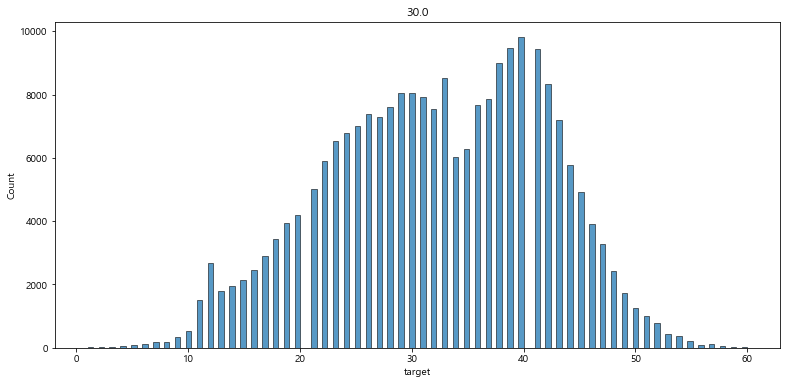

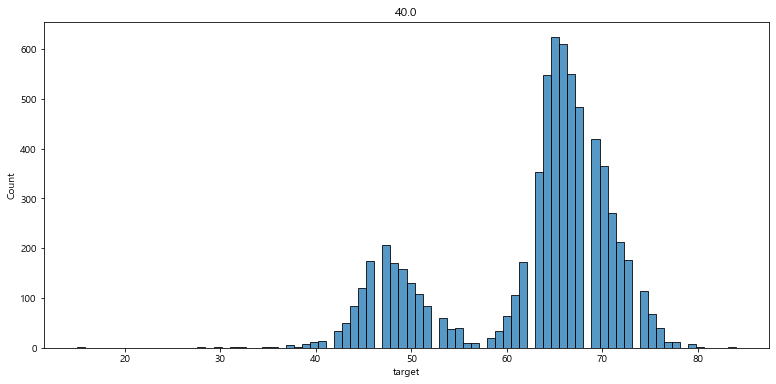

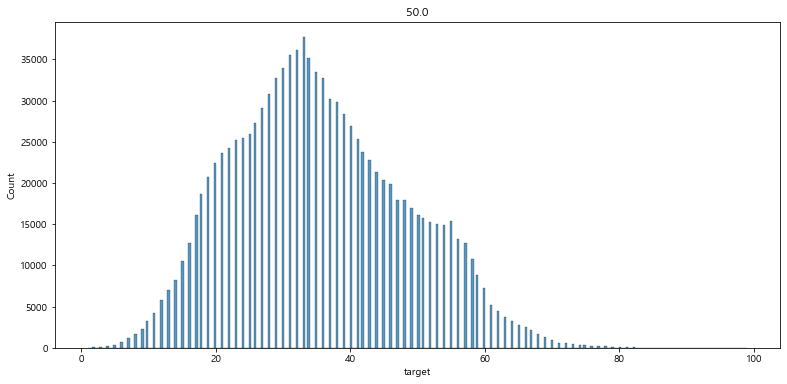

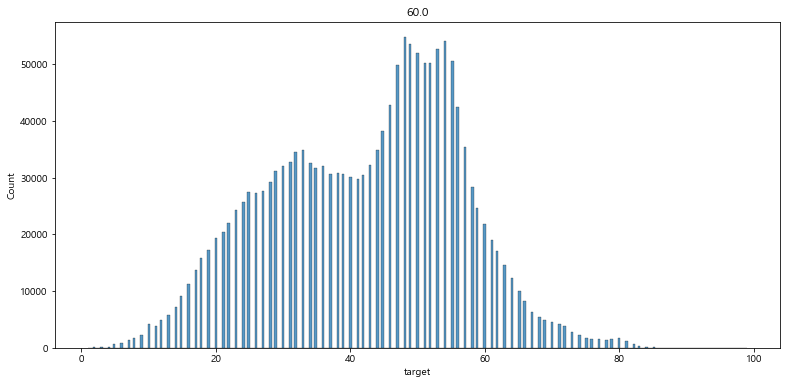

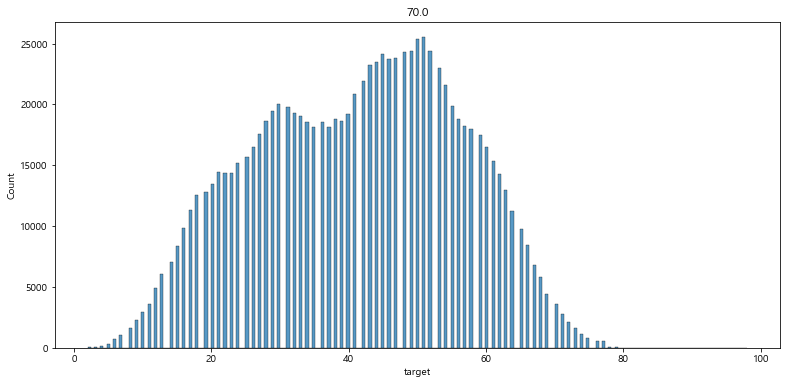

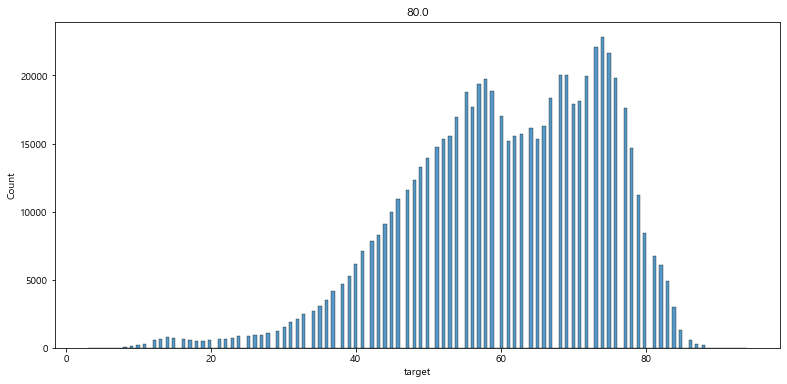

In [82]:
for speed in np.sort(df_train['maximum_speed_limit'].unique()):
    plt.subplots(figsize=(13, 6))
    plt.title(speed)
    sns.histplot(df_train[df_train['maximum_speed_limit']== speed], x='target')

In [84]:
df_train['weight_restricted'].unique()

array([32400.,     0., 43200., 50000.], dtype=float32)

In [86]:
df_train['weight_restricted'].value_counts() / df_train['weight_restricted'].count() # 대부분 하중제한 없음

0.0        0.857836
43200.0    0.087288
32400.0    0.050903
50000.0    0.003973
Name: weight_restricted, dtype: float64

In [85]:
df_train.groupby('weight_restricted').describe()['target'] # 하중제한이 43200인 도로가 target이 높음

,count,mean,std,min,25%,50%,75%,max
weight_restricted,,,,,,,,
0.0,4032870.0,40.944962,15.675570,1.0,29.0,40.0,53.0,99.0
32400.0,239305.0,47.453350,10.299199,3.0,41.0,48.0,55.0,86.0
43200.0,410360.0,57.884121,12.864463,3.0,49.0,55.0,69.0,94.0
50000.0,18677.0,47.088665,4.696219,11.0,46.0,48.0,50.0,67.0


In [65]:
df_train.groupby('road_type').describe()['target']

,count,mean,std,min,25%,50%,75%,max
road_type,,,,,,,,
0,3737113.0,41.151531,15.940455,1.0,29.0,40.0,53.0,99.0
3,964099.0,49.096863,14.316390,3.0,40.0,49.0,57.0,94.0


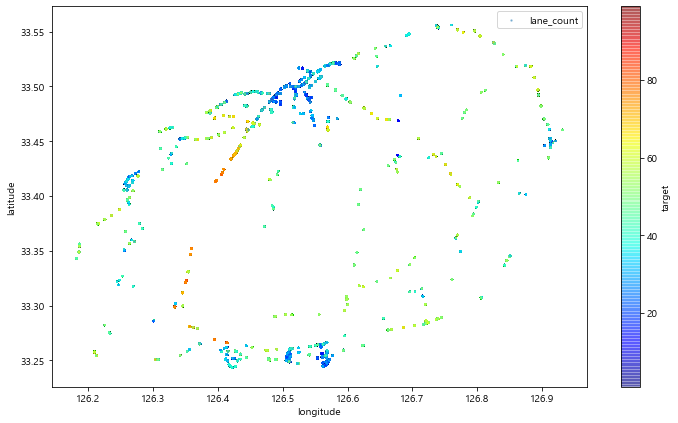

In [53]:
ax=df_train.plot(kind="scatter",x='start_longitude',y='start_latitude',alpha=.4,s=df_train['lane_count'],label='lane_count',
                figsize=(12,7),c='target',cmap=plt.get_cmap('jet'),colorbar=True,sharex=False)
ax.set(xlabel='longitude',ylabel='latitude')
plt.legend() #중부 산간 지방 또는 해안도로주변으로 갈수록 target이 커짐

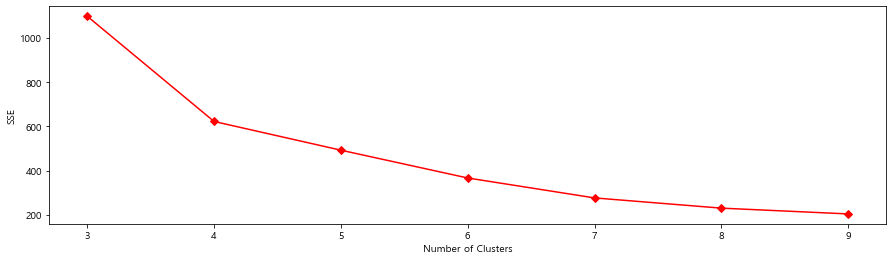

In [18]:
from sklearn.cluster import KMeans

num_of_clusters = range(3,10)
error = []

for num_clusters in num_of_clusters:
    clusters = KMeans(num_clusters)
    clusters.fit(df_train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']])
    error.append(clusters.inertia_/100)
    
plt.figure(figsize=(15,4))
plt.plot(num_of_clusters,error,marker='D',color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [20]:
clusters = KMeans(6)
df_train['loc_clusters'] = clusters.fit_predict(df_train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']])

찾아보니 2006년도에 제주도가 제주특별자치도로 바뀌면서 국도가 지방국도로 격하되었다고 한다.

- 일반국도 12호선 -> 지방도 1132호선
- 일반국도 11호선 -> 지방도 1131호선
- 일반국도 95호선 -> 지방도 1135호선
- 일반국도 16호선 -> 지방도 1136호선
- 일반국도 99호선 -> 지방도 1139호선

하지만 데이터에는 반영이 되지 않아서 같은 도로지만 서로 다른 2개의 표기를 둘다 사용하고 있다.

In [77]:
df_train['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

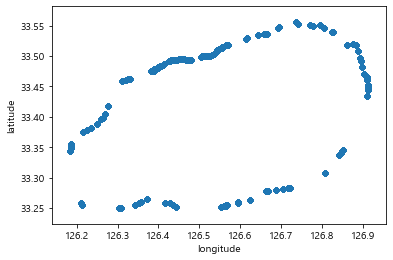

In [78]:
ax=df_train[df_train['road_name']== '일반국도12호선'].plot(kind="scatter",x='start_longitude',y='start_latitude')
ax.set(xlabel='longitude',ylabel='latitude')

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

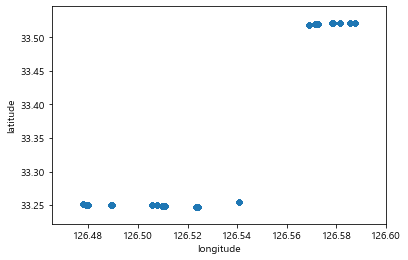

In [79]:
ax=df_train[df_train['road_name']== '지방도1132호선'].plot(kind="scatter",x='start_longitude',y='start_latitude')
ax.set(xlabel='longitude',ylabel='latitude')

# 4. 범주형 자료

In [32]:
categorical_idx = df_train.select_dtypes('object').columns
categorical_idx = categorical_idx.append(pd.Index(['connect_code','road_rating']))
categorical_idx

Index(['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted',
       'end_node_name', 'end_turn_restricted', 'connect_code', 'road_rating'],
      dtype='object')

In [56]:
df_train_categorical = df_train[categorical_idx].copy()
df_train_categorical.head()

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted,connect_code,road_rating
0,목,지방도1112호선,제3교래교,없음,제3교래교,없음,0,106
1,목,일반국도11호선,광양사거리,있음,KAL사거리,없음,0,103
2,일,일반국도16호선,창고천교,없음,상창육교,없음,0,103
3,금,태평로,남양리조트,없음,서현주택,없음,0,107
4,화,일반국도12호선,애월샷시,없음,애월입구,없음,0,103


In [94]:
df_train_categorical['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

In [95]:
df_train_categorical[df_train_categorical['road_name']=='-']

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
6,목,-,가동,없음,나동,없음
14,목,-,송목교,없음,송목교,없음
28,일,-,광평교차로,없음,금악,없음
30,목,-,일호유리,없음,상귀교차로,없음
31,목,-,남수교,없음,남수교,없음
...,...,...,...,...,...,...
4701204,금,-,한남교차로,없음,서중2교,없음
4701205,수,-,감귤창고,없음,수협,없음
4701208,수,-,제2태흥교,없음,제2태흥교,없음
4701212,목,-,대림사거리,없음,금덕해운,없음


In [96]:
print('표기안된 도로 비율: {0:.4f}%'.format(569463/4701217)) # 12프로 어떻게 채울까요???

표기안된 도로 비율: 0.1211%


In [98]:
df_train[df_train['road_name']=='-'].iloc[:,4:13] # road

,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude
6,107,-,0,60.0,0.0,0,가동,33.418412,126.268029
14,107,-,0,60.0,43200.0,3,송목교,33.316913,126.624634
28,107,-,0,50.0,0.0,0,광평교차로,33.330822,126.354179
30,107,-,0,80.0,0.0,0,일호유리,33.472276,126.418443
31,107,-,0,60.0,43200.0,3,남수교,33.337244,126.695809
...,...,...,...,...,...,...,...,...,...
4701204,107,-,0,60.0,0.0,0,한남교차로,33.325096,126.665698
4701205,107,-,0,50.0,0.0,0,감귤창고,33.450215,126.920771
4701208,107,-,0,80.0,43200.0,3,제2태흥교,33.287356,126.736525
4701212,107,-,0,50.0,0.0,0,대림사거리,33.422145,126.278125


# 5. Pipeline

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701216
Data columns (total 26 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int32         
 3   lane_count             int32         
 4   road_rating            int32         
 5   road_name              object        
 6   connect_code           int32         
 7   maximum_speed_limit    float32       
 8   weight_restricted      float32       
 9   road_type              int32         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_latitude           float64       
 16  end_longitude          float64       
 17  end_turn_restricted    object        
 18  target                

In [29]:
change_dtype(df_train, df_train.select_dtypes('int64').columns, 'int32')

In [30]:
df_train = df_train.drop('base_date', axis=1)

In [33]:
from sklearn import preprocessing

for i in categorical_idx:
    le = preprocessing.LabelEncoder()
    le=le.fit(df_train[i])
    df_train[i]=le.transform(df_train[i])

In [99]:
from sklearn.preprocessing import StandardScaler

numerical_idx = ['base_hour', 'lane_count','maximum_speed_limit','weight_restricted','road_type',
                 'start_latitude','start_longitude','end_latitude','end_longitude']

#for i in numerical_idx:
#    scaler = StandardScaler()
#    df_train[[i]]=scaler.fit_transform(df_train[[i]])

In [100]:
df_train.head()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,2022-06-23,1,0.754497,-1.216504,1,46,0,-0.103292,1.919332,1.968826,386,0.429151,0.901272,0,386,0.429178,0.899510,0,52.0
1,2022-07-28,1,1.349550,0.237510,0,34,0,-0.103292,-0.402678,-0.507917,32,1.150319,0.047470,1,2,1.190705,0.029070,0,30.0
2,2021-10-10,4,-0.733137,0.237510,0,36,0,1.545032,-0.402678,-0.507917,426,-1.039229,-0.979028,0,179,-1.030153,-1.020438,0,61.0
3,2022-03-11,0,0.159443,0.237510,2,57,0,-0.927453,-0.402678,-0.507917,58,-1.365946,0.291114,0,203,-1.371146,0.284827,0,20.0
4,2021-10-05,6,-0.584373,0.237510,0,35,0,1.545032,-0.402678,-0.507917,267,0.769730,-1.247927,0,269,0.774334,-1.225077,0,38.0


# 5. Multicollinearity

In [101]:
corrs  = df_train.corr().sort_values('target', ascending=False)
threshold = .8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
above_threshold_vars

{'day_of_week': ['day_of_week'],
 'base_hour': ['base_hour'],
 'lane_count': ['lane_count'],
 'road_rating': ['road_rating'],
 'road_name': ['road_name'],
 'connect_code': ['connect_code'],
 'maximum_speed_limit': ['maximum_speed_limit'],
 'weight_restricted': ['weight_restricted'],
 'road_type': ['road_type'],
 'start_node_name': ['start_node_name'],
 'start_latitude': ['start_latitude', 'end_latitude'],
 'start_longitude': ['end_longitude', 'start_longitude'],
 'start_turn_restricted': ['start_turn_restricted'],
 'end_node_name': ['end_node_name'],
 'end_latitude': ['start_latitude', 'end_latitude'],
 'end_longitude': ['end_longitude', 'start_longitude'],
 'end_turn_restricted': ['end_turn_restricted'],
 'target': ['target']}